In [1]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
from matplotlib.ticker import MaxNLocator

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rc('legend',fontsize=12, title_fontsize=12) # using a named size

In [3]:
pattern = r"Code block 'i=(\d+), force_host_read=([^,]+), blocksize='([^']+)', cufile_params=(None|'cufile_thread_count=(\d+), cufile_slice_size_mb=(\d+)')' took: ([^\s]+) ms"

In [4]:
with open("slurm-693520.out") as f:
    logs = f.read()

In [5]:
def parse_blocksize(text):
    return {
        "512MiB": 0.5,
        "1GiB": 1,
        "2GiB": 2,
        "4GiB": 4
    }[text]

measurements = []

for match in re.findall(pattern, logs):
    # We remove first "warmup" observation
    if (rep := int(match[0])) > 0:
        measurements.append({
            "rep": rep,
            "GDS": bool(match[4]),
            "data transfer path": "Storage-GPU (GDS)" if match[4] else "Storage-CPU-GPU",
            "blocksize (GiB)": parse_blocksize(match[2]),
            "number of\nIO threads": int(match[4]) if match[4] else 0,
            "time (msecs)": float(match[6]),
            "lib": "metajsonparser"
        })
measurements_df = pd.DataFrame(measurements)

In [6]:
cudf_pattern = r"""Code block 'blocksize='([^']+)', os\.environ\['LIBCUDF_CUFILE_POLICY'\]='([^']+)', os\.environ\.get\('LIBCUDF_CUFILE_THREAD_COUNT'\)=([^,]+), os\.environ\.get\('LIBCUDF_CUFILE_SLICE_SIZE'\)=(.+)' took: ([^\s]+) ms
rows="""

measurements_cudf = []

with open("cudf-parser/slurm-707604.out") as f:
    logs = f.read()
    
    for match in re.findall(cudf_pattern, logs, re.M):
    # We remove first "warmup" observation
        measurements_cudf.append({
            "blocksize (GiB)": parse_blocksize(match[0]),
            "GDS": False,
            "data transfer path": "Storage-CPU-GPU",
            "number of\nIO threads": None,
            "time (msecs)": float(match[-1]),
            "lib": "cudf"
        })
measurements_cudf_df = pd.DataFrame(measurements_cudf)

In [7]:
comparison_df = measurements_df[measurements_df["number of\nIO threads"].isin([0, 64])]

In [8]:
comparison_df.groupby("GDS").mean()

/tmp/ipykernel_18607/2263933760.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  comparison_df.groupby("GDS").mean()


,rep,blocksize (GiB),number of\nIO threads,time (msecs)
GDS,,,,
False,3.0,1.875,0.0,154305.400209
True,3.0,1.875,64.0,36897.491259


In [9]:
154305.400209 / 36897.491259

4.182002486994613

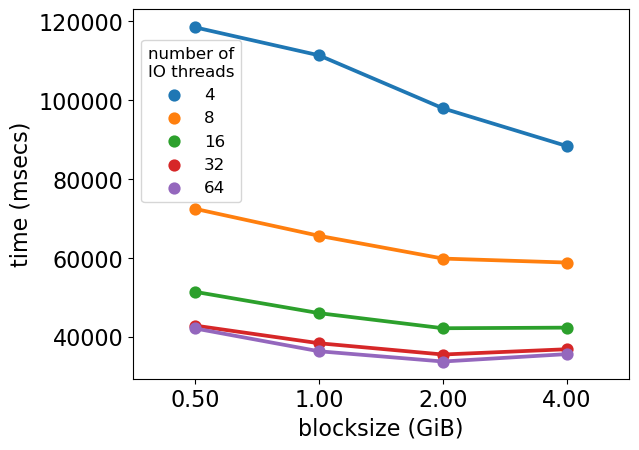

In [10]:
gds_df = measurements_df[
    measurements_df["GDS"]
]
g = sns.pointplot(
    data=gds_df,
    x="blocksize (GiB)",
    y="time (msecs)",
    hue=gds_df["number of\nIO threads"].astype(int),
    palette=sns.color_palette(n_colors=gds_df["number of\nIO threads"].nunique()),
    errorbar="se"
)
sns.move_legend(g, 'upper left', bbox_to_anchor=(0, 0.94))
g.set_xticks(g.get_xticks(), labels=['{:.2f}'.format(float(t.get_text())) for t in g.get_xticklabels()])
plt.savefig(f"img/dask-gds-time.pdf", format="pdf", bbox_inches='tight')
plt.show()

## Comparison between GDS and non-GDS:

In [11]:
measurements_cudf_df

,blocksize (GiB),GDS,data transfer path,number of\nIO threads,time (msecs),lib
0,0.5,False,Storage-CPU-GPU,None,470275.42773,cudf
1,1.0,False,Storage-CPU-GPU,None,474434.98116,cudf
2,0.5,False,Storage-CPU-GPU,None,484062.96604,cudf
3,1.0,False,Storage-CPU-GPU,None,482196.06402,cudf
4,0.5,False,Storage-CPU-GPU,None,482070.97905,cudf
5,1.0,False,Storage-CPU-GPU,None,478122.26544,cudf
6,0.5,False,Storage-CPU-GPU,None,485711.55090,cudf
7,1.0,False,Storage-CPU-GPU,None,480296.06149,cudf
8,0.5,False,Storage-CPU-GPU,None,485147.77421,cudf
9,1.0,False,Storage-CPU-GPU,None,478135.98068,cudf


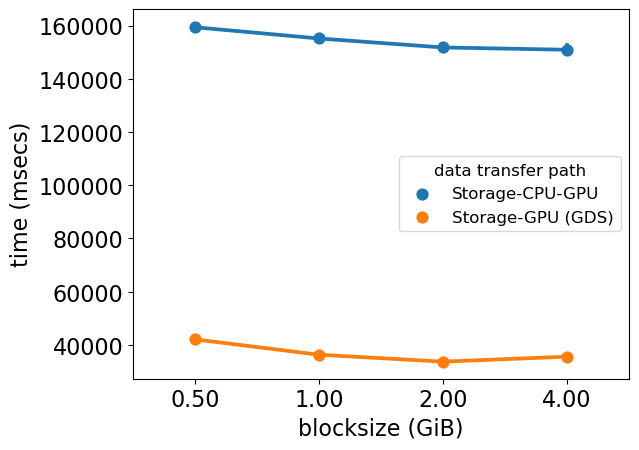

In [12]:
comparison_df = measurements_df[measurements_df["number of\nIO threads"].isin([0, 64])]
fig, ax = plt.subplots()
# sns.pointplot(
#     data=measurements_cudf_df,
#     x="blocksize (GiB)",
#     y="time (msecs)",
#     hue="data transfer path",
#     palette=sns.color_palette(n_colors=2),
#     errorbar="se",
#     linestyles="dotted",
#     markers="."
# )
g = sns.pointplot(
    data=comparison_df,
    x="blocksize (GiB)",
    y="time (msecs)",
    hue="data transfer path",
    palette=sns.color_palette(n_colors=2),
    errorbar="se",
)
g.set_xticks(g.get_xticks(), labels=['{:.2f}'.format(float(t.get_text())) for t in g.get_xticklabels()])
plt.savefig(f"img/dask-comparison-time.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [13]:
measurements_cudf_df

,blocksize (GiB),GDS,data transfer path,number of\nIO threads,time (msecs),lib
0,0.5,False,Storage-CPU-GPU,None,470275.42773,cudf
1,1.0,False,Storage-CPU-GPU,None,474434.98116,cudf
2,0.5,False,Storage-CPU-GPU,None,484062.96604,cudf
3,1.0,False,Storage-CPU-GPU,None,482196.06402,cudf
4,0.5,False,Storage-CPU-GPU,None,482070.97905,cudf
5,1.0,False,Storage-CPU-GPU,None,478122.26544,cudf
6,0.5,False,Storage-CPU-GPU,None,485711.55090,cudf
7,1.0,False,Storage-CPU-GPU,None,480296.06149,cudf
8,0.5,False,Storage-CPU-GPU,None,485147.77421,cudf
9,1.0,False,Storage-CPU-GPU,None,478135.98068,cudf


In [14]:
measurements_cudf_df.groupby("blocksize (GiB)").mean()

/tmp/ipykernel_18607/2015178551.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  measurements_cudf_df.groupby("blocksize (GiB)").mean()


,GDS,time (msecs)
blocksize (GiB),,
0.5,0.0,481704.001213
1.0,0.0,478442.093357


In [15]:
measurements_df

,rep,GDS,data transfer path,blocksize (GiB),number of\nIO threads,time (msecs),lib
0,1,False,Storage-CPU-GPU,0.5,0,158008.86017,metajsonparser
1,2,False,Storage-CPU-GPU,0.5,0,158352.26963,metajsonparser
2,3,False,Storage-CPU-GPU,0.5,0,159807.40981,metajsonparser
3,4,False,Storage-CPU-GPU,0.5,0,160234.51848,metajsonparser
4,5,False,Storage-CPU-GPU,0.5,0,160468.89158,metajsonparser
...,...,...,...,...,...,...,...
115,1,True,Storage-GPU (GDS),4.0,64,35286.93603,metajsonparser
116,2,True,Storage-GPU (GDS),4.0,64,35196.78217,metajsonparser
117,3,True,Storage-GPU (GDS),4.0,64,36083.84151,metajsonparser
118,4,True,Storage-GPU (GDS),4.0,64,35341.77490,metajsonparser


In [16]:
measurements_df[measurements_df.GDS & (measurements_df["number of\nIO threads"] == 64)].groupby("blocksize (GiB)").mean()

/tmp/ipykernel_18607/3483883543.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  measurements_df[measurements_df.GDS & (measurements_df["number of\nIO threads"] == 64)].groupby("blocksize (GiB)").mean()


,rep,GDS,number of\nIO threads,time (msecs)
blocksize (GiB),,,,
0.5,3.0,1.0,64.0,42062.347186
1.0,3.0,1.0,64.0,36280.222916
2.0,3.0,1.0,64.0,33685.204708
4.0,3.0,1.0,64.0,35562.190228


In [17]:
480/42

11.428571428571429

In [18]:
measurements_df[~measurements_df.GDS].groupby("blocksize (GiB)").mean()

/tmp/ipykernel_18607/930999192.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  measurements_df[~measurements_df.GDS].groupby("blocksize (GiB)").mean()


,rep,GDS,number of\nIO threads,time (msecs)
blocksize (GiB),,,,
0.5,3.0,0.0,0.0,159374.389934
1.0,3.0,0.0,0.0,155149.146998
2.0,3.0,0.0,0.0,151782.041370
4.0,3.0,0.0,0.0,150916.022536
